In [23]:
import argparse
import pickle

import matplotlib.pyplot as plt
import numpy as np
import torch
from joblib import Parallel, delayed
from collections import OrderedDict
from utilities.meta_utils import tensors_to_device

import matplotlib.pyplot as plt

from learner.BasicLearner import BasicLearner
from learner.ResidualPerturbatedMAML import ResidualPerturbatedMAML
from network.meta_network import MetaNetworkWithPertubation, NoisyMetaNetwork
from task.TaskGenerator import SinTaskGenerator
from utilities.folder_management import handle_folder_creation


In [24]:
# Network parameters
INPUT_SIZE = 1
OUTPUT_SIZE = 1
HIDDEN_SIZE = (64, 64, 64)

TRAINING_EPOCHS = 10
TEST_PERCENTAGE = 0.2

NET_LR = 0.01

# Meta parameters
FIRST_ORDER = False
RES_STOCHASTIC_ITERATION = 30
RES_LR = 0.001

# Dataset parameters
MIN_X = -5
MAX_X = 5

BATCH_SIZE = 128
LATER_BATCH_SIZE = 10

NUM_BATCH_FIRST_TASK = 1000
NUM_BATCH_LATER_TASK = 5

MAX_BATCHES_FIRST_TASK = 2000
MAX_BATCHES_LATER_TASK = 30

SIMULATE_MAX_BATCHES = 1000
SIMULATE_BATCH_SIZE = 32
SIMULATE_N_BATCHES = 250
SIMULATE_TEST_SPLIT = 0.2

# Task parameters
AMPLITUDE_LIST = [1, 1.4, 1.8, 2.2, 2.8, 3.2, 3.6, 4.0, 4.4, 4.0, 3.6, 3.2, 3.6, 3.2, 3.2, 2.8]
PHASE_LIST = [0, 0.3, 0.6, 0.8, 1.0, 1.3, 1.6, 1.3, 1.6, 1.3, 1.0, 1.5, 1.8, 1.4, 1.5, 1.3]
n_tasks = len(AMPLITUDE_LIST)

In [45]:
task_generator: SinTaskGenerator = SinTaskGenerator(x_min=MIN_X, x_max=MAX_X)
device = "cpu"

init_mean_w_output = torch.zeros(HIDDEN_SIZE[-1], device=device)
init_std_w_output = 0.3*torch.ones(HIDDEN_SIZE[-1], device=device)
init_mean_b_output = torch.zeros(OUTPUT_SIZE, device=device)
init_std_b_output = 0.3*torch.ones(OUTPUT_SIZE, device=device)

init_mean_w_input = torch.zeros(HIDDEN_SIZE[0], device=device)
init_std_w_input = torch.ones(HIDDEN_SIZE[0], device=device)
init_mean_b_input = torch.zeros(HIDDEN_SIZE[0], device=device)
init_std_b_input = torch.ones(HIDDEN_SIZE[0], device=device)

init_input_mean = torch.zeros(1, device=device)
init_input_std = 0.3 * torch.ones(1, device=device)

task_0_net: torch.nn.Module = NoisyMetaNetwork(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                               init_mean_w_output=init_mean_w_output, 
                                               init_std_w_output=init_std_w_output,
                                               init_mean_b_output=init_mean_b_output, 
                                               init_std_b_output=init_std_b_output,
                                               init_mean_w_input=init_mean_w_input.unsqueeze(1), 
                                               init_std_w_input=init_std_w_input.unsqueeze(1),
                                               init_mean_b_input=init_std_b_input,
                                               init_std_b_input=init_std_b_input,
                                               init_input_mean=init_input_mean,
                                               init_input_std=init_input_std
                                               )

residual_net: torch.nn.Module = NoisyMetaNetwork(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                               init_mean_w_output=init_mean_w_output, 
                                               init_std_w_output=init_std_w_output,
                                               init_mean_b_output=init_mean_b_output, 
                                               init_std_b_output=init_std_b_output,
                                               init_mean_w_input=init_mean_w_input.unsqueeze(1), 
                                               init_std_w_input=init_std_w_input.unsqueeze(1),
                                               init_mean_b_input=init_std_b_input,
                                               init_std_b_input=init_std_b_input,
                                               init_input_mean=init_input_mean,
                                               init_input_std=init_input_std
                                               )

loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(residual_net.parameters(), lr=0.1)
net_opt = torch.optim.Adam(task_0_net.parameters(), lr=0.01)
learner: ResidualPerturbatedMAML = ResidualPerturbatedMAML(network=task_0_net,
                                                           residual_network=residual_net,
                                                           n_in=INPUT_SIZE,
                                                           n_out=OUTPUT_SIZE,
                                                           net_optimizer=net_opt,
                                                           net_loss_function=loss,
                                                           maml_optimizer=optimizer,
                                                           maml_loss_function=loss,
                                                           net_scheduler=None,
                                                           x_space=task_generator.x_space,
                                                           device=device,
                                                           first_order=FIRST_ORDER,
                                                           learn_step_size=True)
                                                    

In [43]:
# Train first model
# data_loader_task_0 = task_generator.get_data_loader(amplitude=AMPLITUDE_LIST[0], test_perc=0.2,phase=PHASE_LIST[0], num_batches=3000, batch_size=128)

In [44]:
learner.train(data_loader_task_0, 10000)

  5%|▍         | 455/10000 [00:02<00:57, 166.17it/s, loss=0.0223]


KeyboardInterrupt: 

In [12]:
torch.save(learner.network.state_dict(), "good_model_task_0")

In [46]:
learner.network.load_state_dict(torch.load("good_model_task_0"))

<All keys matched successfully>

In [47]:
from torch.distributions.normal import Normal

learner.network.w_perturbation_dist_output = Normal(init_mean_w_output, init_std_w_output)
learner.network.b_perturbation_dist_output = Normal(init_mean_b_output, init_std_b_output)
learner.network.input_perturbation = Normal(init_input_mean, init_input_std)


In [48]:
def plot(task_generator, amplitude_list, phase_list, model, perturbation=False, p_iter=5,
        plot_true=False, legend=False, plot_res=False):
    x_points = task_generator.x_space
    
    if plot_true:
        i = 0
        for a, p in zip(amplitude_list, phase_list):
            y_points = a * torch.sin(x_points - p)
            plt.plot(x_points[0], y_points[0], label="Task {}".format(i))
            i += 1
    
    if perturbation:
        for i in range(0, p_iter):
            if plot_res:
                y = model(task_generator.x_space[0].unsqueeze(1), perturbation=True).detach()
                y -= model(task_generator.x_space[0].unsqueeze(1), perturbation=False).detach()
            else:
                y = model(task_generator.x_space[0].unsqueeze(1), perturbation=perturbation).detach()
            plt.plot(x_points[0],y, label="Net {}".format(i))
    else:
        plt.plot(x_points[0], model(task_generator.x_space[0].unsqueeze(1), perturbation=perturbation).detach(), label="Net")
    
    if legend:
        plt.legend()
    plt.show()

In [49]:
def plot_model_list(task_generator, amplitude_list, phase_list, model_list, plot_true=False):
    x_points = task_generator.x_space
    
    if plot_true:
        i = 0
        for a, p in zip(amplitude_list, phase_list):
            y_points = a * torch.sin(x_points - p)
            plt.plot(x_points[0], y_points[0], label="Task {}".format(i))
            i += 1
    
    for i in range(len(model_list)):
        plt.plot(x_points[0], model_list[i](task_generator.x_space[0].unsqueeze(1)).detach(), label="Net {}".format(i))
    
    plt.legend()
    plt.show()

In [50]:
def plot_model_sum(task_generator, amplitude_list, phase_list, model_1, model_2):
    x_points = task_generator.x_space
    
    i = 0
    for a, p in zip(amplitude_list, phase_list):
        y_points = a * torch.sin(x_points - p)
        plt.plot(x_points[0], y_points[0], label="Task {}".format(i))
        i += 1
    
    p_1 = model_1(task_generator.x_space[0].unsqueeze(1)).detach()
    p_2 = model_2(task_generator.x_space[0].unsqueeze(1)).detach()
    plt.plot(x_points[0],p_1+p_2 , label="Net {}".format(i))
    plt.legend()
    plt.show()

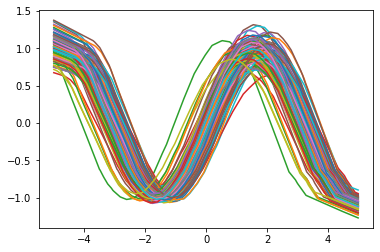

In [57]:
plot(task_generator,  AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], learner.network, perturbation=True, p_iter=100,
        plot_true=False, legend=False, plot_res=False)

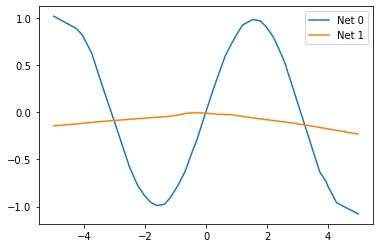

In [53]:
plot_model_list(task_generator, AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], [learner.network, learner.maml.network])

In [67]:
SIMULATE_MAX_BATCHES = [1000, 3000]
SIMULATE_BATCH_SIZE = 32
SIMULATE_N_BATCHES = [250, 700, 1000, 1500, 3000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]
SIMULATE_TEST_SPLIT = 0.2
n_trials = len(SIMULATE_MAX_BATCHES)

learner_list = []
step_size_list = []

learner.maml.network.set_learn_net(True)
for i in range(n_trials):
    n_batches = SIMULATE_N_BATCHES[i] 
    max_batches = SIMULATE_MAX_BATCHES[i] if i == 0 else SIMULATE_MAX_BATCHES[i] - SIMULATE_MAX_BATCHES[i-1]
    
    print(OrderedDict(learner.maml.network.named_meta_parameters())['layer1.weight'][0:5])
    
    learner.simulate_meta_training(num_batches=n_batches,
                                   batch_size=SIMULATE_BATCH_SIZE,
                                   test_split=SIMULATE_TEST_SPLIT,
                                   max_batches=max_batches,
                                   verbose=True)
    new_model: torch.nn.Module = NoisyMetaNetwork(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                               init_mean_w_output=init_mean_w_output, 
                                               init_std_w_output=init_std_w_output,
                                               init_mean_b_output=init_mean_b_output, 
                                               init_std_b_output=init_std_b_output,
                                               init_mean_w_input=init_mean_w_input.unsqueeze(1), 
                                               init_std_w_input=init_std_w_input.unsqueeze(1),
                                               init_mean_b_input=init_std_b_input,
                                               init_std_b_input=init_std_b_input,
                                               init_input_mean=init_input_mean,
                                               init_input_std=init_input_std
                                               )
    new_model.load_state_dict(learner.maml.network.state_dict())
    new_model.set_learn_net(False)
    new_model.set_learn_noise(False)
    learner_list.append(new_model)
    step_size_list.append(learner.maml.step_size.item())

tensor([[ 0.3623],
        [-1.0909],
        [ 0.1705],
        [-0.2077],
        [ 0.2164]], grad_fn=<SliceBackward>)


100%|██████████| 1000/1000 [00:43<00:00, 23.09it/s, loss=0.0431]


tensor([[ 0.3623],
        [-1.0911],
        [ 0.1703],
        [-0.2076],
        [ 0.2164]], grad_fn=<SliceBackward>)


 15%|█▍        | 299/2000 [00:12<01:13, 23.03it/s, loss=0.0238]


KeyboardInterrupt: 

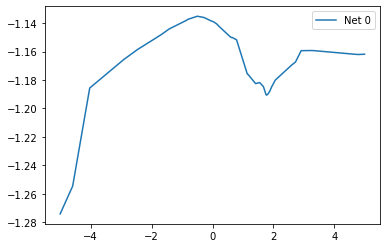

In [68]:
plot_model_list(task_generator, AMPLITUDE_LIST[0:2], PHASE_LIST[0:2], learner_list)

In [69]:
# Storing after meta results
after_meta_list = []
for net in learner_list:
    new_model = NoisyMetaNetwork(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                               init_mean_w_output=init_mean_w_output, 
                                               init_std_w_output=init_std_w_output,
                                               init_mean_b_output=init_mean_b_output, 
                                               init_std_b_output=init_std_b_output,
                                               init_mean_w_input=init_mean_w_input.unsqueeze(1), 
                                               init_std_w_input=init_std_w_input.unsqueeze(1),
                                               init_mean_b_input=init_std_b_input,
                                               init_std_b_input=init_std_b_input,
                                               init_input_mean=init_input_mean,
                                               init_input_std=init_input_std
                                               )
    new_model.load_state_dict(net.state_dict())
    new_model.set_learn_net(False)
    new_model.set_learn_noise(False)
    after_meta_list.append(new_model)

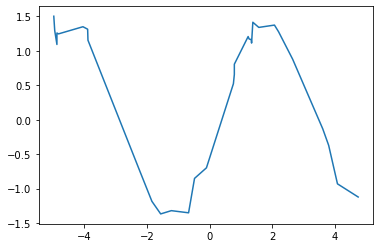

In [91]:
# Adaptation to task 1... let's see how it goes...
task = 1
num_batches = NUM_BATCH_FIRST_TASK if task == 0 else 1
bs = BATCH_SIZE if task == 0 else 40
max_batches = MAX_BATCHES_FIRST_TASK if task == 0 else MAX_BATCHES_LATER_TASK

data_loader_2 = task_generator.get_data_loader(amplitude=AMPLITUDE_LIST[task],
                                                     phase=PHASE_LIST[task],
                                                     num_batches=num_batches,
                                                     batch_size=bs,
                                                     test_perc=TEST_PERCENTAGE)
idx = data_loader_2[0]['train'][0].squeeze(1).sort().indices
plt.plot(data_loader_2[0]['train'][0][idx], data_loader_2[0]['train'][1][idx])

In [101]:
data_loader_2[0]['train'][0].squeeze(1).sort()

torch.return_types.sort(
values=tensor([-4.9700, -4.9400, -4.8700, -4.8700, -4.8200, -4.0400, -3.8900, -3.8800,
        -2.2400, -1.8400, -1.5600, -1.2200, -0.6700, -0.4800, -0.1000,  0.7600,
         0.7900,  0.7900,  1.2300,  1.2600,  1.3300,  1.3400,  1.3800,  1.5700,
         2.0700,  2.2000,  2.6500,  3.6100,  3.7800,  3.8000,  4.0800,  4.7400]),
indices=tensor([23, 11,  3, 19, 26, 12, 14, 31, 28,  2,  1, 24,  6, 29,  7, 15, 10, 21,
        27, 22, 30, 17, 13,  9,  5,  4, 18, 20, 16,  8,  0, 25]))

In [107]:
# Storing after meta results
learner_list = []
for net in after_meta_list:
    new_model = NoisyMetaNetwork(n_in=INPUT_SIZE, n_out=OUTPUT_SIZE, hidden_sizes=HIDDEN_SIZE,
                                               init_mean_w_output=init_mean_w_output, 
                                               init_std_w_output=init_std_w_output,
                                               init_mean_b_output=init_mean_b_output, 
                                               init_std_b_output=init_std_b_output,
                                               init_mean_w_input=init_mean_w_input.unsqueeze(1), 
                                               init_std_w_input=init_std_w_input.unsqueeze(1),
                                               init_mean_b_input=init_std_b_input,
                                               init_std_b_input=init_std_b_input,
                                               init_input_mean=init_input_mean,
                                               init_input_std=init_input_std
                                               )
    new_model.load_state_dict(net.state_dict())
    new_model.set_learn_net(False)
    new_model.set_learn_noise(False)
    learner_list.append(new_model)

after_adaptation_list = []
for i, net in enumerate(learner_list):
    net.set_learn_net(True)
    net.set_learn_noise(True)
    learner.maml.network = net
    learner.step_size = step_size_list[i]
    new_adaptation(learner, data_loader_2, 50)
    after_adaptation_list.append(learner.maml.network)

In [108]:
def new_adaptation(l, data_loader, max_batches):
    num_batches = 0
    optim = torch.optim.SGD(l.maml.network.parameters(), lr=l.maml.step_size.item(), momentum=0.)

    # Adaptation to the new task
    while num_batches < max_batches:
        for batch in data_loader:
            if num_batches >= max_batches:
                break
            batch = tensors_to_device(batch['train'], device=l.device)
            for i in range(l.maml.num_adaptation_steps):
                inputs = batch[0]
                target = batch[1] - l.network(inputs).detach()
                optim.zero_grad()
                pred = l.maml.network(inputs) 
                loss = l.loss_function(pred, target)
                loss.backward()
                optim.step()
            num_batches += 1


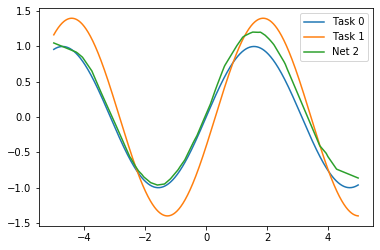

In [109]:
plot_model_sum(task_generator=task_generator, amplitude_list=AMPLITUDE_LIST[0:2],
               phase_list=PHASE_LIST[0:2], model_1=learner.network, model_2=after_adaptation_list[0])

In [ ]:
OrderedDict(after_meta_list[0].named_meta_parameters())['layer1.weight'] - OrderedDict(after_meta_list[8].named_meta_parameters())['layer1.weight']

In [179]:
after_meta_list[1](torch.tensor([1], dtype=torch.float32))

tensor([-0.0207])

In [79]:
OrderedDict(learner.maml.network.named_meta_parameters())

OrderedDict([('layer1.weight', Parameter containing:
              tensor([[ 0.3382],
                      [-1.0513],
                      [ 0.1864],
                      [-0.3234],
                      [ 0.4431],
                      [ 0.1161],
                      [ 0.4080],
                      [-0.5345],
                      [ 0.0340],
                      [ 0.1655],
                      [ 0.2175],
                      [ 0.3576],
                      [-0.0719],
                      [-0.2173],
                      [-0.1495],
                      [ 0.0875],
                      [ 0.1010],
                      [-0.3851],
                      [ 0.2249],
                      [ 0.3422],
                      [-0.1278],
                      [ 0.2022],
                      [-0.3691],
                      [ 0.0827],
                      [ 0.0463],
                      [ 0.0463],
                      [-0.1136],
                      [-0.0665],
                      [

In [66]:
learner_list

[]